<a href="https://colab.research.google.com/github/wazir-ali-haideri/autonomous-line-follower-using-reinforcement-learning/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium stable-baselines3 shimmy matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 6.9 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


🧠 Training on Zig-Zag Track (Hard Mode)...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 56.3     |
|    ep_rew_mean     | 9.83     |
| time/              |          |
|    fps             | 1673     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 67           |
|    ep_rew_mean          | 20.6         |
| time/                   |              |
|    fps                  | 1332         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0059588645 |
|    clip_fraction        | 0.0468       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | -0.00858     |
|    learning_rate        | 0.0003       |
|    loss                 | 288          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00934     |
|    std                  | 0.989        |
|    value_loss           | 774          |
------------------------------------------
------------------------------------------
| rollout/ 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✅ Video Saved: robot_zigzag.mp4


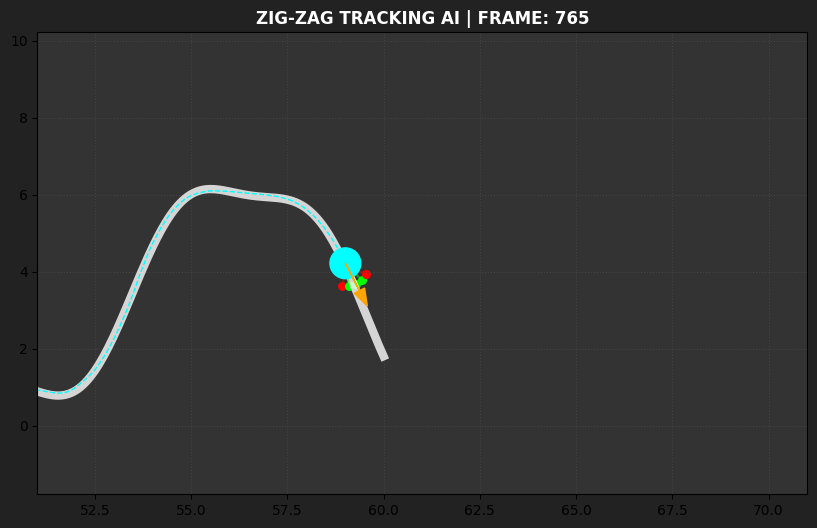

In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from stable_baselines3 import PPO
import math
import os

# --- CONFIGURATION ---
TRACK_LENGTH = 60       # Meters
RESOLUTION = 1000       # Points in the line
SENSOR_COUNT = 5
SENSOR_SPREAD = 0.8     # Wider spread to catch sharp turns
SENSOR_REACH = 0.6
ROBOT_WIDTH = 0.5
ROBOT_LENGTH = 0.8
MAX_SPEED = 1.2
MAX_TURN = 3.0          # Sharper turning ability needed for zigzags

class AdvancedLineFollowerEnv(gym.Env):
    """
    Advanced Robot Environment with Complex Zig-Zag Tracks.
    """
    def __init__(self):
        super(AdvancedLineFollowerEnv, self).__init__()

        # Action: [Velocity (0 to 1), Steering (-1 to 1)]
        self.action_space = spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)

        # Observation: [5 Sensors, Speed, Ang_Vel]
        self.observation_space = spaces.Box(low=0, high=1, shape=(SENSOR_COUNT + 2,), dtype=np.float32)

        self.track_points = []
        self.trajectory = []

    def _generate_complex_track(self):
        """
        Generates a track with Zig-Zags and S-Bends.
        """
        x = np.linspace(0, TRACK_LENGTH, RESOLUTION)

        # 1. Base Curve (Big winding path)
        freq1 = np.random.uniform(0.1, 0.2)
        y = np.sin(x * freq1) * 4.0

        # 2. The Zig-Zag Component (Medium freq, high amplitude)
        # This creates the sharp "Snake" movement
        freq2 = np.random.uniform(0.5, 0.8)
        y += np.sin(x * freq2) * 2.5

        # 3. Micro-Jitter (Adds roughness/unpredictability)
        freq3 = np.random.uniform(1.5, 2.0)
        y += np.sin(x * freq3) * 0.5

        return np.column_stack((x, y))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.track_points = self._generate_complex_track()

        # Start at index 0
        start_pos = self.track_points[0]

        # Calculate heading towards index 5 (look ahead slightly)
        look_idx = 5
        dx = self.track_points[look_idx][0] - start_pos[0]
        dy = self.track_points[look_idx][1] - start_pos[1]
        start_heading = math.atan2(dy, dx)

        self.pos = np.array([start_pos[0], start_pos[1]], dtype=np.float32)
        self.heading = start_heading
        self.vel = 0.0
        self.ang_vel = 0.0

        self.current_step = 0
        self.trajectory = [self.pos.copy()]
        self.sensor_readings = self._read_sensors()

        return self._get_obs(), {}

    def _read_sensors(self):
        """5 IR Sensors looking for the line"""
        readings = np.zeros(SENSOR_COUNT, dtype=np.float32)

        # Arc arrangement of sensors for better corner detection
        sensor_angles = np.linspace(-0.6, 0.6, SENSOR_COUNT) # Radians spread

        for i, angle_offset in enumerate(sensor_angles):
            # Global angle for this sensor
            global_angle = self.heading + angle_offset

            # Position: relative to robot center
            sx = self.pos[0] + SENSOR_REACH * np.cos(global_angle)
            sy = self.pos[1] + SENSOR_REACH * np.sin(global_angle)

            # Distance to track
            # Optimization: Only check points relatively close to robot x
            # (Crude optimization but fast for this scale)
            idx_est = int((self.pos[0] / TRACK_LENGTH) * RESOLUTION)
            start_search = max(0, idx_est - 50)
            end_search = min(RESOLUTION, idx_est + 50)

            if start_search < end_search:
                local_track = self.track_points[start_search:end_search]
                dists = np.linalg.norm(local_track - np.array([sx, sy]), axis=1)
                min_dist = np.min(dists)
            else:
                min_dist = 10.0 # Lost

            # Binary Output: 1 if line < 0.25m away, else 0
            readings[i] = 1.0 if min_dist < 0.25 else 0.0

        return readings

    def _get_obs(self):
        self.sensor_readings = self._read_sensors()
        return np.concatenate([
            self.sensor_readings,
            [self.vel / MAX_SPEED],
            [self.ang_vel / MAX_TURN]
        ], dtype=np.float32)

    def step(self, action):
        self.current_step += 1

        # 1. Action Mapping
        target_speed = np.clip((action[0] + 1) / 2, 0, 1) * MAX_SPEED
        target_turn = np.clip(action[1], -1, 1) * MAX_TURN

        # 2. Physics (Inertia)
        self.vel += (target_speed - self.vel) * 0.15
        self.ang_vel += (target_turn - self.ang_vel) * 0.2

        self.heading += self.ang_vel * 0.1
        self.pos[0] += self.vel * np.cos(self.heading) * 0.1
        self.pos[1] += self.vel * np.sin(self.heading) * 0.1

        self.trajectory.append(self.pos.copy())

        # 3. Reward Calculation
        # Find closest point on track
        idx_est = int((self.pos[0] / TRACK_LENGTH) * RESOLUTION)
        start_search = max(0, idx_est - 100)
        end_search = min(RESOLUTION, idx_est + 100)

        if start_search >= end_search:
            error_dist = 10.0
        else:
            local_track = self.track_points[start_search:end_search]
            dists = np.linalg.norm(local_track - self.pos, axis=1)
            error_dist = np.min(dists)

        reward = 0

        # SPEED BONUS (Only if accurate)
        if error_dist < 0.2:
            reward += self.vel * 3.0 # High reward for going fast on line
        elif error_dist < 0.5:
            reward += self.vel * 0.5 # Low reward if drifting
        else:
            reward -= 1.0 # Penalty for being off

        # CENTER SENSOR BONUS (Crucial for ZigZags)
        if self.sensor_readings[2] == 1.0: # Middle sensor
            reward += 2.0

        terminated = False
        truncated = False

        # TERMINATION
        if error_dist > 1.2: # Lost the line
            reward -= 50.0
            terminated = True

        if self.pos[0] >= TRACK_LENGTH - 1.0: # Finished
            reward += 200.0
            terminated = True
            print("✅ COURSE COMPLETED!")

        if self.current_step >= 1000:
            truncated = True

        return self._get_obs(), reward, terminated, truncated, {}

# --- VISUALIZATION ---

def render_complex_track(env, model, filename="robot_zigzag.mp4"):
    print(f"\n🎥 Rendering Complex ZigZag Track: {filename}")

    frames = []
    obs, _ = env.reset()

    for _ in range(1000):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, term, trunc, _ = env.step(action)

        frames.append({
            'pos': env.pos.copy(),
            'heading': env.heading,
            'sensors': env.sensor_readings.copy(),
            'track': env.track_points,
            'traj': np.array(env.trajectory)
        })
        if term or trunc:
            for _ in range(30): frames.append(frames[-1])
            break

    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('#222') # Dark Mode background
    ax.set_facecolor('#333')

    def update(i):
        ax.clear()
        data = frames[i]

        # 1. Track (White Line)
        track = data['track']
        ax.plot(track[:,0], track[:,1], color='white', linewidth=6, alpha=0.8)

        # 2. Trajectory (Cyan Trail)
        if len(data['traj']) > 1:
            ax.plot(data['traj'][:,0], data['traj'][:,1], color='cyan', linewidth=1, linestyle='--')

        # 3. Robot
        px, py = data['pos']
        h = data['heading']

        # Robot Body
        robot_circle = plt.Circle((px, py), 0.4, color='cyan', zorder=10)
        ax.add_patch(robot_circle)

        # Direction Indicator
        ax.arrow(px, py, np.cos(h)*0.8, np.sin(h)*0.8, head_width=0.3, color='orange', zorder=11)

        # 4. Sensors
        sensor_angles = np.linspace(-0.6, 0.6, SENSOR_COUNT)
        for idx, angle in enumerate(sensor_angles):
            ga = h + angle
            sx = px + SENSOR_REACH * np.cos(ga)
            sy = py + SENSOR_REACH * np.sin(ga)

            # Green if HIT, Red if MISS
            color = '#00ff00' if data['sensors'][idx] > 0.5 else '#ff0000'
            ax.plot([px, sx], [py, sy], color=color, alpha=0.5)
            ax.scatter(sx, sy, color=color, s=30)

        # Camera Follow
        ax.set_xlim(px - 8, px + 12)
        ax.set_ylim(py - 6, py + 6)
        ax.set_aspect('equal')
        ax.grid(True, color='#444', linestyle=':')

        ax.set_title(f"ZIG-ZAG TRACKING AI | FRAME: {i}", color='white', fontweight='bold')

    anim = FuncAnimation(fig, update, frames=len(frames), interval=30)

    try:
        writer = FFMpegWriter(fps=30, bitrate=4000, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
        anim.save(filename, writer=writer)
        print(f"✅ Video Saved: {filename}")
    except:
        anim.save("zigzag.gif", writer='pillow', fps=20)

# --- EXECUTION ---
if __name__ == "__main__":
    os.makedirs('models', exist_ok=True)

    env = AdvancedLineFollowerEnv()
    print("🧠 Training on Zig-Zag Track (Hard Mode)...")

    # Needs more steps to learn sharp turns
    model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0003)
    model.learn(total_timesteps=90000)

    render_complex_track(env, model)